In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
from scipy.special import factorial
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions')
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [47]:
##### investigate .datx files
coat_labels =  ('0', '1', '2', '3', '4', '5_sn1', '5_sn2', '5_sn3')
mat_sizes = []

# find the smallest size to calibrate all the optics to this size
for cl in coat_labels:
    fileloc = 'oaps/oap_coated/uncentered_data/oap{0}_mx_ca.datx'.format(cl)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fileloc)
    print('n{0} diameter: {1:.3f}'.format(cl, sp['diam_mm']))
    surf, mask = dfx.mat_tight(surf,mask)
    mat_sizes.append(np.shape(mask))
min_side = np.amin(mat_sizes) # pray this is reasonable
if min_side % 2 != 0: # if not even
    min_side -= 1 # decrease by 1 to make even

n0 diameter: 40.328 mm
n1 diameter: 40.432 mm
n2 diameter: 40.432 mm
n3 diameter: 40.432 mm
n4 diameter: 40.432 mm
n5_sn1 diameter: 40.432 mm
n5_sn2 diameter: 40.432 mm
n5_sn3 diameter: 40.432 mm


In [51]:
(min_side * sp['lateral_res']*u.pix)/(0.05*u.m)

<Quantity 0.80551281>

In [46]:
sp

{'wavelength': <Quantity 6.32799981e-07 m>,
 'scale_factor': 0.5,
 'units': 'micron',
 'lateral_res': <Quantity 5.21705188e-05 m / pix>,
 'diam_pix': <Quantity 775. pix>,
 'diam_mm': <Quantity 40.43215204 mm>}

In [44]:
# resize all the data
for cl in coat_labels:
    # call in the file
    fileloc = 'oaps/oap_coated/uncentered_data/oap{0}_mx_ca.datx'.format(cl)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fileloc)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)
    
    # resize the matrix for it to be same size
    surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=(np.int(np.shape(mask)[0] - min_side)))

    # check that the matrix is even (required for the PSD code)
    if np.shape(surf)[0] % 2 != 0: # odd matrix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)

    # apply the changes onto the dictionary
    sp['opt_diam'] = 50 * u.mm
    sp['diam_pix'] = np.shape(mask)[0]*u.pix
    sp['diam_mm'] = (sp['diam_pix'] * sp['lateral_res']).to(u.mm)
    sp['ca'] = (sp['diam_mm'] / sp['opt_diam']) * 100

    # save the raw file
    raw_file = 'oaps/oap_coated/flat_2in_n{0}_step{1}_raw'.format(fm_num, ns)
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=raw_file, save_mask=False)

    # change the surface back into units of OPD
    surf_fix = surf_fix_phase * k_num
    
    # write data to a matrix
    if ns==0: # initialize first time
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize first
    data_set[ns, :, :] = surf_fix.value

    # write all this to a FITS file
    fits_file = fits_folder+'flat_2in_n{0}_step{1}'.format(fm_num, ns)
    #dfx.write_fits(surface=surf_fix, mask=mask, surf_parms=sp, filename=fits_file)

772

(775, 775)


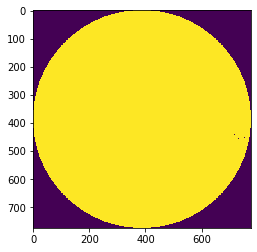

In [30]:
surf, mask = dfx.mat_tight(surf, mask)
print(np.shape(mask))
plt.imshow(mask)